##### Download, normalize and split vol cube data into train/test datasets

In [3]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

# Download the data
from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, opt_tenors, swap_tenors, strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
dataset_split_type = 'random_split'
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                   seed = 0,
                                                                                   train_ratio=0.8,
                                                                                   type=dataset_split_type)
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Load the saved model and its history from the file

In [4]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vae_van_leaky_randomsplit_3_200_100_50_25_3000ep_bat16_1e-5'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Plot history of train and test losses against the epochs

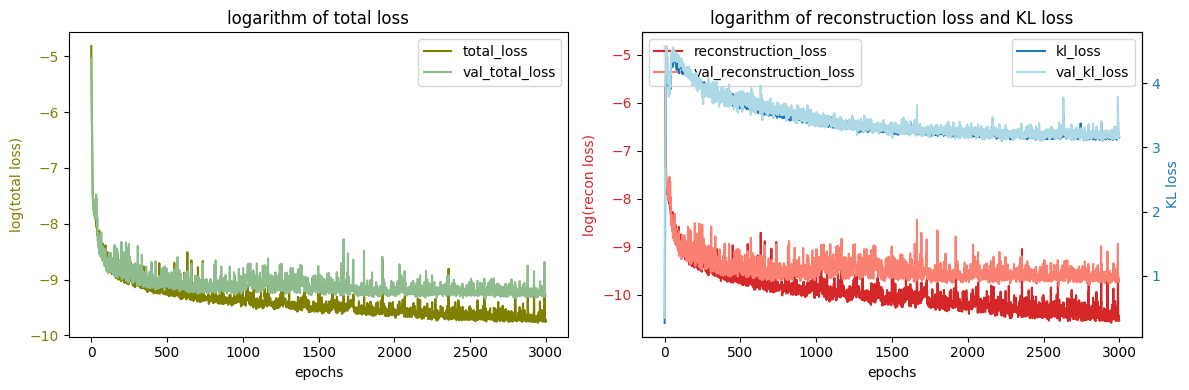

In [5]:
from src.visualization.plot_history_of_losses import plot_history_of_losses
plot_history_of_losses(history,
                       data_type='vol')

# Compress

##### Plot 2d latent space values

For each date, based on vol cube test data, we calculate latent space values z0, z1 and z2

The latent space variables (z0, z1, z2) for train dataset look similar to the Gaussian distribution - that's why Kullback-Leibner loss is small

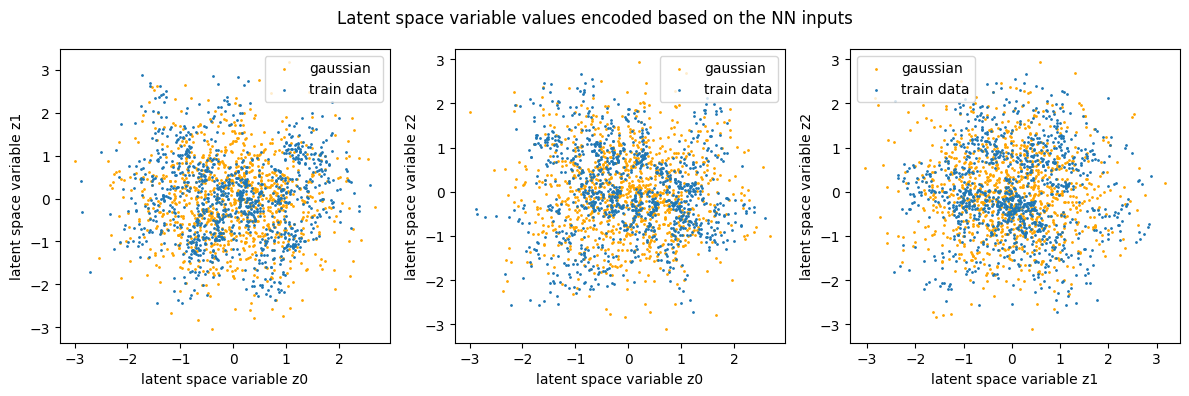

In [6]:
from src.visualization.vol.scatplot_latent_space_3d_values import scatplot_latent_space_3d_values
scatplot_latent_space_3d_values(vae, 
                            label1='gaussian',
                            label2='train data',
                            data2=data_norm_train)

The distribution for latent space variables (z0, z1 and z2) for train and test datasets can be found below. The distributions are similar, so the results of compressing, completing and generating volatility cubes for this model and random splitting are good.

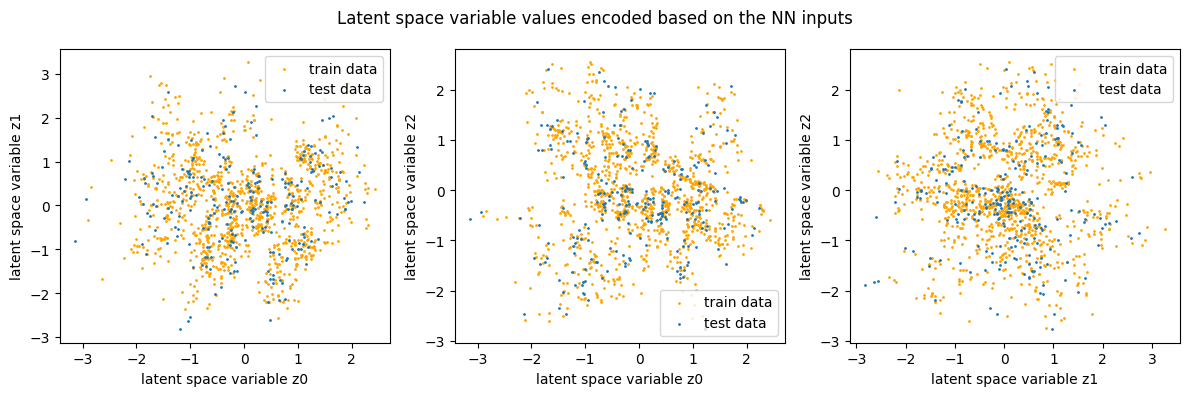

In [7]:
from src.visualization.vol.scatplot_latent_space_3d_values import scatplot_latent_space_3d_values
scatplot_latent_space_3d_values(vae, 
                                label1='train data',
                                data1=data_norm_train,
                                label2='test data',
                                data2=data_norm_test)

##### Error histograms

Error histogram shows the distribution of errors. Each error is the difference between real volatility value and reconstructed volatility value from VAE for a certain data point (with a certain strike, swap tenor and option tenor) in volatility cube and a certain date. Mean (and max) is calculated over all dates and data points in vol cube.

##### Error histograms for train dataset:

Mean error 0.82
Max error 51.64


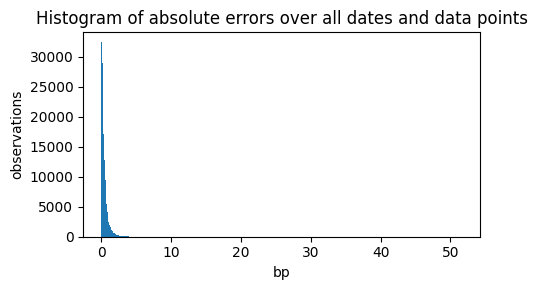

In [8]:
from src.visualization.vol.hist_errors import hist_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_train, verbose=0))
hist_errors(predictions,
                 data_train,
                 bins=500)

##### Error histograms for test dataset:

Mean error 1.35
Max error 40.91


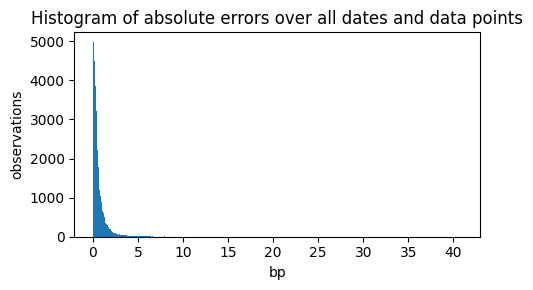

In [9]:
from src.visualization.vol.hist_errors import hist_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
hist_errors(predictions,
                 data_test,
                 bins=500)

In [10]:
THRESHOLD = 5 # bp
diffs = abs(predictions - data_test).reshape(-1)
print(f'percentage of errors in test dataset smaller than {THRESHOLD}bp is {(1 - len(diffs[diffs > THRESHOLD]) / len(diffs)) * 100:.1f}%')

percentage of errors in test dataset smaller than 5bp is 99.1%


As we can see from the graph above, mean Average error is 1.35bp which is significantly less than bid-ask spread for IR vols.

Max error is about 40bp which is comparable to the bid-ask spread for large (246bp) vol values.

##### "Predictions vs real data" graphs on the test dataset

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


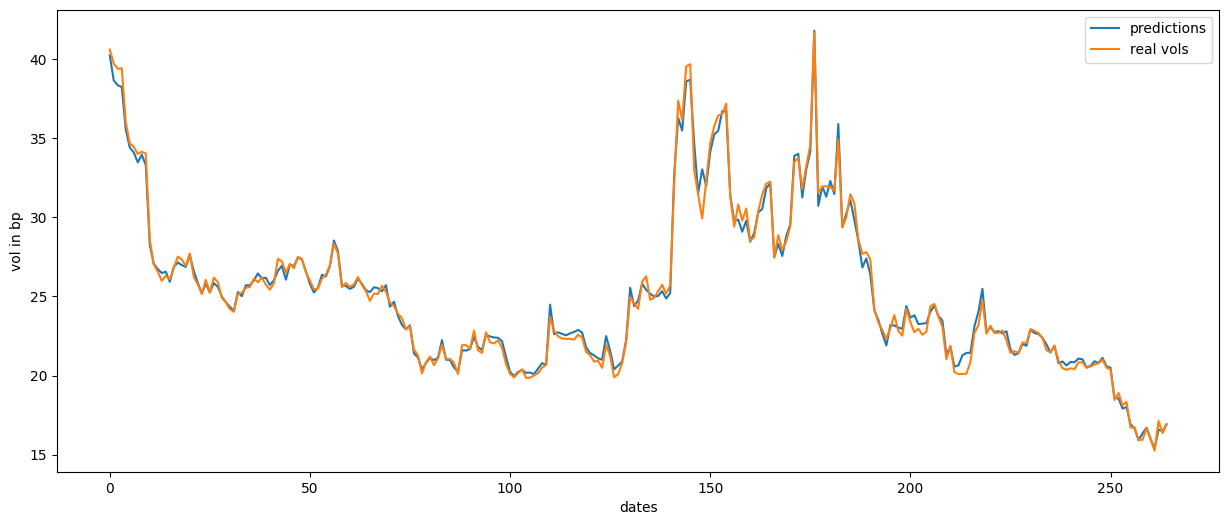

In [11]:
from src.visualization.vol.plot_real_vs_prediction_vols import plot_real_vs_prediction_vols

N1 = 5  # option tenor index (10Y)
N2 = 4  # swap tenor index (10Y)
N3 = 2  # strike index (ATM)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plot_real_vs_prediction_vols(predictions=predictions,
                             real_vols=data_test,
                             indexes=[N1, N2, N3])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


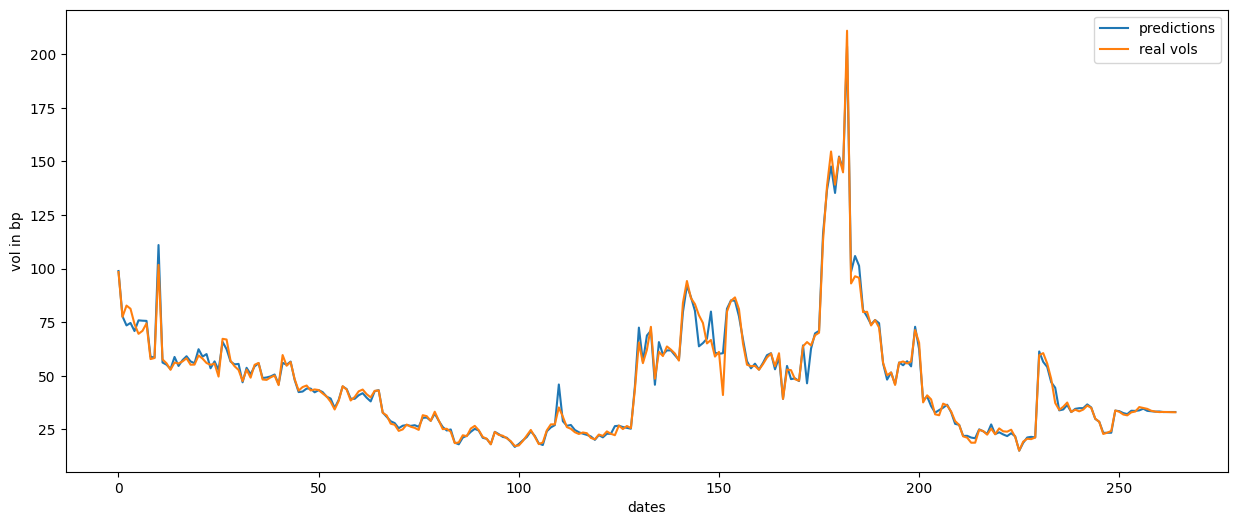

In [12]:
import matplotlib.pyplot as plt
N1 = 0  # option tenor index (1M)
N2 = 0  # swap tenor index (1Y)
N3 = 0  # strike index (ATM-100bp)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plot_real_vs_prediction_vols(predictions=predictions,
                             real_vols=data_test,
                             indexes=[N1, N2, N3])

##### Error grids for different tenors and strikes on the test dataset

For each option tenor, swap tenor and strike, we calculate MEAN error over all dates in test dataset

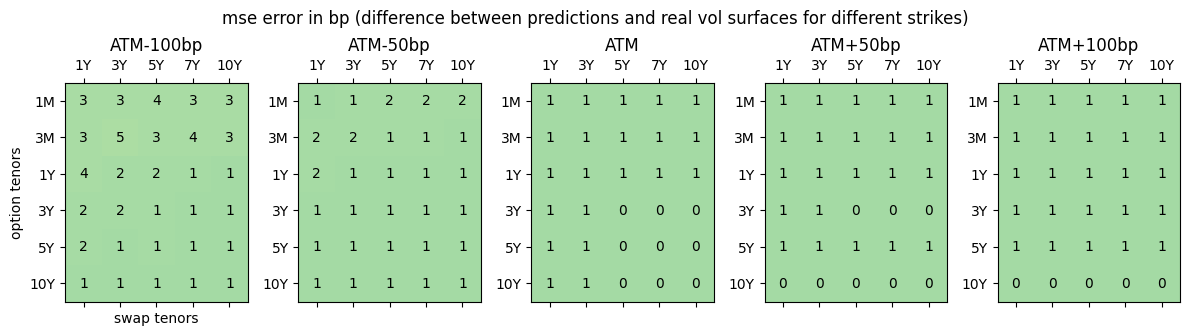

In [13]:
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
grids_vol_cube_errors(predictions,
                     data_test,
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mse'
                     )

For each option tenor, swap tenor and strike, we calculate MAX error over all dates in test dataset

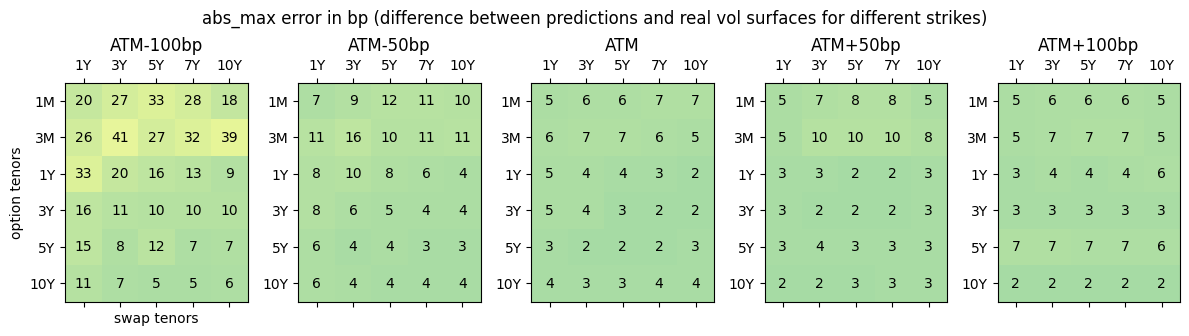

In [14]:
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
grids_vol_cube_errors(predictions,
                     data_test,
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='abs_max'
                     )

# Analyze

##### Changing of vol cube data when we change z0, z1 and z2 values

* When latent space variable z0 is large, we see larger values for short-term vols. So, z0 is responsible for higher short-term vols.

* When latent space variable z1 is large, we see that vol surfaces for different strikes started to differ. So, z1 is responsible for smile

* When latent space variable z2 is large, all vols are low and when z2 is very negative, all vols are huge. So, z2 is responsible for overall level of volatilities

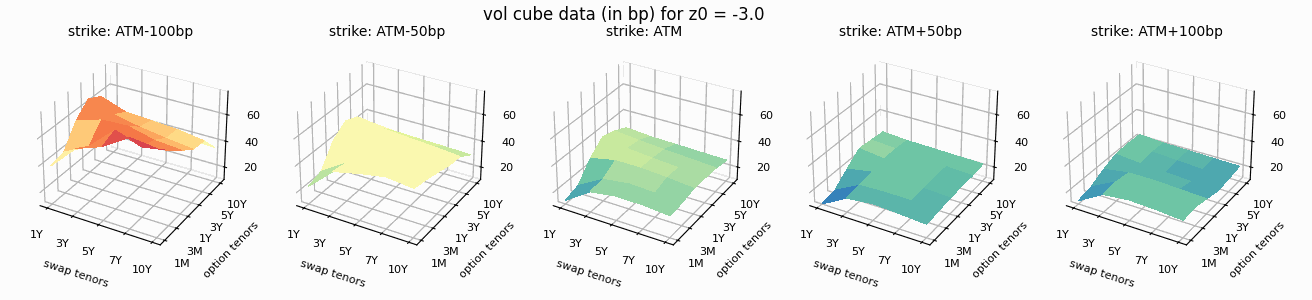

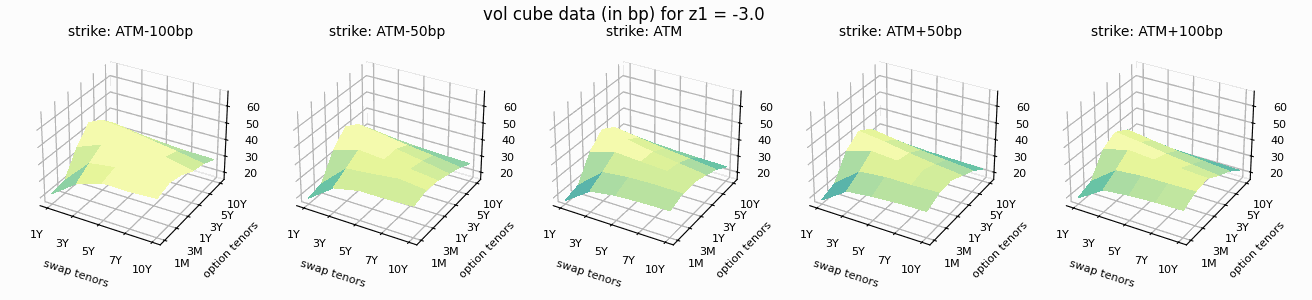

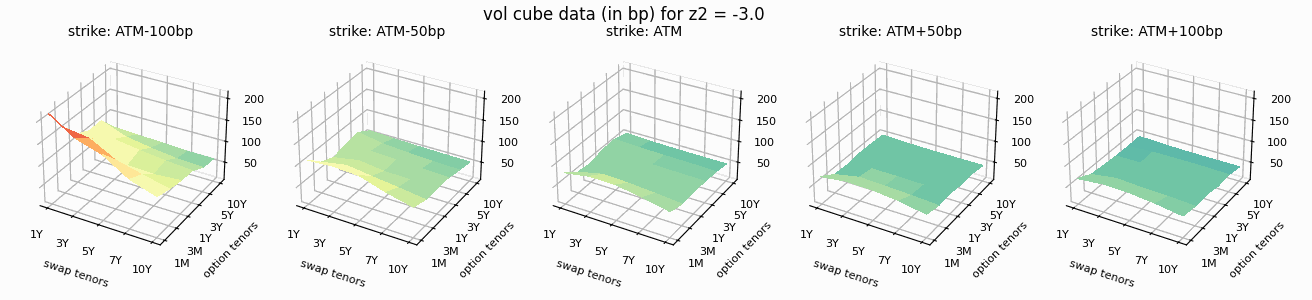

In [15]:
from src.visualization.vol.gif_vol_cube_for_diff_z import gif_vol_cube_for_diff_z

for z_idx in range(vae.latent_space_dim):
    gif_vol_cube_for_diff_z(vae,
                            normalizer,
                            all_z_vals=[0] * vae.latent_space_dim,
                            z_idx=z_idx,
                            x_labels=swap_tenors,
                            y_labels=opt_tenors,
                            strikes=strikes,
                            delete_pngs=True,
                            save_name= NAME + '_diff_z' + str(z_idx)
                            )

# Complete

### Let's assume that ATM vols are missed for the date with largest vols

##### Create dataset with missed values

In [16]:
# Select index in test dataset for the date with largest vol
if dataset_split_type == 'random_split':
    date_idx = 0   # the date with largest vols that we will investigate     
elif dataset_split_type == 'temporal_split':
    date_idx = 12  # the date with largest vols that we will investigate
# Select the missed strike
missed_strikes = [2]   # 0 is ATM-100bp, 1 is ATM-50bp, 2 is ATM, 3 is ATM+50bp, 4 is ATM+100bp

# Import what value is considered as a missed value
from references.global_parameters import MISSED_VALUE

# Create dataset with missed values
data_test_missed = data_test.copy()
for missed_stk in missed_strikes:
    data_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

# Create normalized dataset with missed values
data_norm_test_missed = data_norm_test.copy()
for missed_stk in missed_strikes:
    data_norm_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

##### Draw real volatility cube data for one date and volatility cube data for this date with missed ATM vols

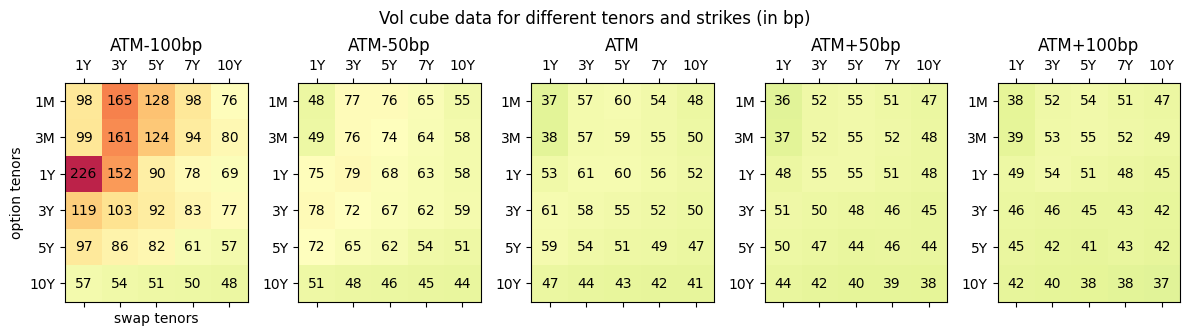

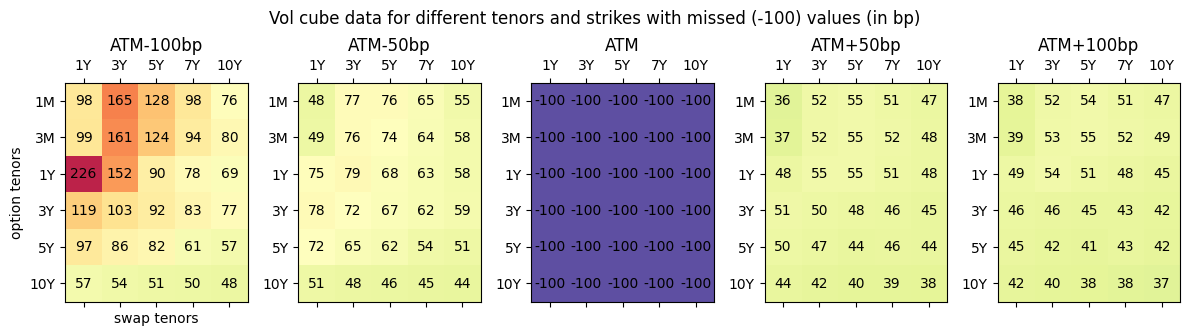

In [17]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube

# Draw real data grid
grids_vol_cube(data=data_test[date_idx],
               x_labels=swap_tenors,
               y_labels=opt_tenors,
               strikes=strikes)

# Draw grid of real data with missed values
grids_vol_cube(data=data_test_missed[date_idx],
               x_labels=swap_tenors,
               y_labels=opt_tenors,
               strikes=strikes)

Find optimal latent space variables z such that reconstructed volatility cube is the closest to the vol cube with missed data from above.

In [18]:
from src.utils.vol.find_z_to_complete_vol_cube import find_z_to_complete_vol_cube
z_optimal = find_z_to_complete_vol_cube(vae=vae,
                                        data=data_norm_test_missed[date_idx],
                                        random_attempt_num=5, # number of attempts starting from different random z initial values
                                        random_seed=0,
                                        print_status=True
                                        )

iteration #0
z_initial [5.29215704 1.20047163 2.93621395]
z_optimal [-1.08310367  0.53121142 -2.16367033]
current mse 0.2524399580393471
best mse 0.2524399580393471
----------------------
iteration #1
z_initial [ 6.7226796   5.60267397 -2.93183364]
z_optimal [-1.01678582 -1.53735029 -2.20081675]
current mse 0.007888022050432042
best mse 0.007888022050432042
----------------------
iteration #2
z_initial [ 2.85026525 -0.45407162 -0.30965656]
z_optimal [-1.01670549 -1.53741149 -2.20086836]
current mse 0.007888021726178682
best mse 0.007888021726178682
----------------------
iteration #3
z_initial [1.23179551 0.43213071 4.36282052]
z_optimal [-1.01670549 -1.53741149 -2.20086836]
current mse 0.007888023169193566
best mse 0.007888021726178682
----------------------
iteration #4
z_initial [2.28311318 0.36502505 1.3315897 ]
z_optimal [-1.01670549 -1.53741149 -2.20086836]
current mse 0.008116073371029028
best mse 0.007888021726178682
----------------------


Complete the missed data in vol cube and check errors against real data

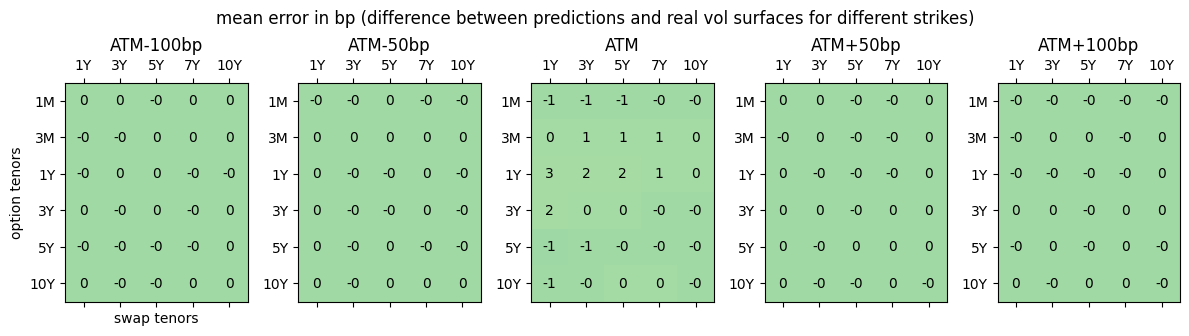

z_real [-0.94, -1.51, -2.16]
z_optimal [-1.02, -1.54, -2.2]
avg error over all data points 0.43 bp


In [19]:
# z_optimal = [-1.01670549, -1.53741149, -2.20086836]
import numpy as np
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.decoder.predict(np.array([z_optimal]), verbose=0))  # shape=(1,6,5,7)

for i in range(predictions.shape[1]):
    for j in range(predictions.shape[2]):
        for k in range(predictions.shape[3]):
            if data_test_missed[date_idx, i, j, k] != MISSED_VALUE:
                predictions[0, i, j, k] = data_test[date_idx, i, j, k]

grids_vol_cube_errors(predictions=predictions,
                     data=np.expand_dims(data_test[date_idx],0),
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mean',  # mse, mean or abs_max
                     )

z_real = vae.encoder.predict(x=np.expand_dims(data_norm_test[date_idx],0), verbose=0)[0][0]
print(f'z_real {[round(x,2) for x in z_real]}')
print(f'z_optimal {[round(x,2) for x in z_optimal]}')
print(f'avg error over all data points {((predictions - np.expand_dims(data_test[date_idx],0))**2).mean()**0.5:.2f} bp')

### Let's assume that all values except ATM vols will be missed for the date with largest vols

##### Create dataset with missed values

In [20]:
# Select index in test dataset for the date with largest vol
if dataset_split_type == 'random_split':
    date_idx = 0   # the date with largest vols that we will investigate     
elif dataset_split_type == 'temporal_split':
    date_idx = 12  # the date with largest vols that we will investigate
# Select the missed strike
missed_strikes = [0, 1, 3, 4]   # 0 is ATM-100bp, 1 is ATM-50bp, 2 is ATM, 3 is ATM+50bp, 4 is ATM+100bp

# Import what value is considered as a missed value
from references.global_parameters import MISSED_VALUE

# Create dataset with missed values
data_test_missed = data_test.copy()
for missed_stk in missed_strikes:
    data_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

# Create normalized dataset with missed values
data_norm_test_missed = data_norm_test.copy()
for missed_stk in missed_strikes:
    data_norm_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

##### Draw real volatility cube data for one date and volatility cube data for this date with missed ATM vols

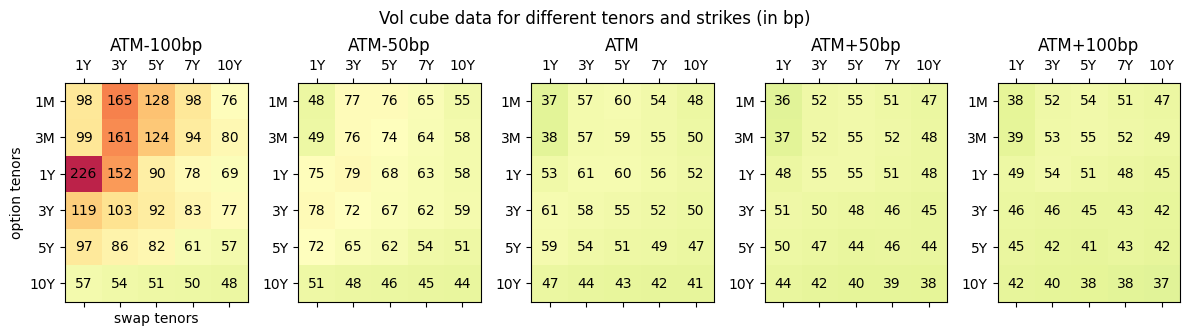

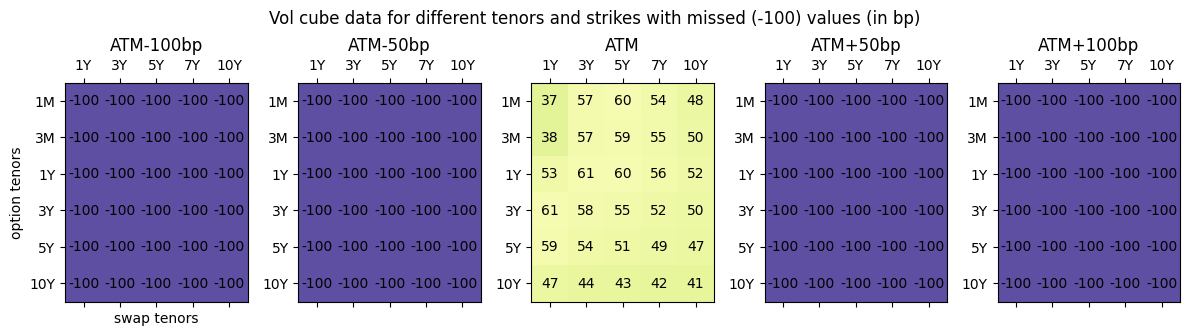

In [21]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube

# Draw real data grid
grids_vol_cube(data=data_test[date_idx],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)

# Draw grid of real data with missed values
grids_vol_cube(data=data_test_missed[date_idx],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)

Find optimal latent space variables z such that reconstructed volatility cube is the closest to the vol cube with missed data from above.

In [22]:
from src.utils.vol.find_z_to_complete_vol_cube import find_z_to_complete_vol_cube
z_optimal = find_z_to_complete_vol_cube(vae=vae,
                                        data=data_norm_test_missed[date_idx],
                                        random_attempt_num=5, # number of attempts starting from different random z initial values
                                        random_seed=0,
                                        print_status=True
                                        )

iteration #0
z_initial [5.29215704 1.20047163 2.93621395]
z_optimal [-2.00041009  0.22008625 -2.11074544]
current mse 0.013455174087484536
best mse 0.013455174087484536
----------------------
iteration #1
z_initial [ 6.7226796   5.60267397 -2.93183364]
z_optimal [-2.00041009  0.22008625 -2.11074544]
current mse 0.3402268045337881
best mse 0.013455174087484536
----------------------
iteration #2
z_initial [ 2.85026525 -0.45407162 -0.30965656]
z_optimal [-0.89256418 -1.62579527 -2.19317728]
current mse 0.0003744148054252191
best mse 0.0003744148054252191
----------------------
iteration #3
z_initial [1.23179551 0.43213071 4.36282052]
z_optimal [-0.89256418 -1.62579527 -2.19317728]
current mse 0.05584461615677049
best mse 0.0003744148054252191
----------------------
iteration #4
z_initial [2.28311318 0.36502505 1.3315897 ]
z_optimal [-0.89256418 -1.62579527 -2.19317728]
current mse 0.035006808718677396
best mse 0.0003744148054252191
----------------------


Complete the missed data in vol cube and check errors against real data

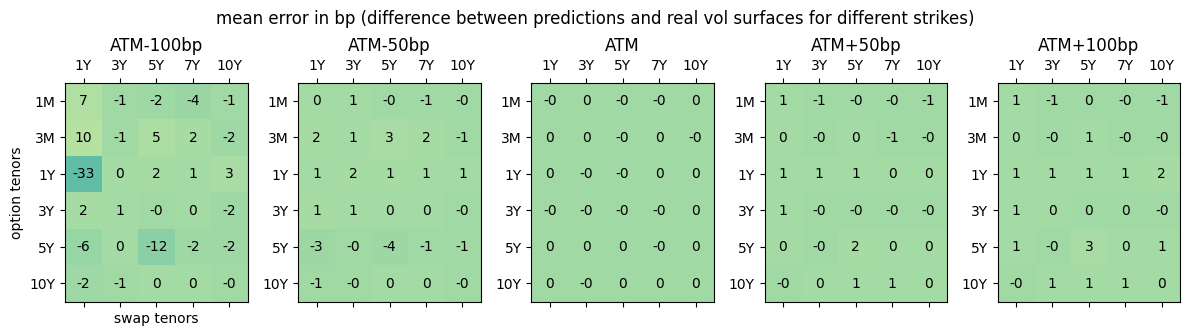

z_real [-0.94, -1.51, -2.16]
z_optimal [-0.89, -1.63, -2.19]
avg error over all data points 3.29 bp


In [24]:
# z_optimal = [-0.89205942, -1.62552034, -2.19303542]
import numpy as np
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.decoder.predict(np.array([z_optimal]), verbose=0))  # shape=(1,6,5,7)

for i in range(predictions.shape[1]):
    for j in range(predictions.shape[2]):
        for k in range(predictions.shape[3]):
            if data_test_missed[date_idx, i, j, k] != MISSED_VALUE:
                predictions[0, i, j, k] = data_test[date_idx, i, j, k]
                
grids_vol_cube_errors(predictions=predictions,
                     data=np.expand_dims(data_test[date_idx],0),
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mean'  # mse, mean or abs_max
                     )

z_real = vae.encoder.predict(x=np.expand_dims(data_norm_test[date_idx],0), verbose=0)[0][0]
print(f'z_real {[round(x,2) for x in z_real]}')
print(f'z_optimal {[round(x,2) for x in z_optimal]}')
print(f'avg error over all data points {((predictions - np.expand_dims(data_test[date_idx],0))**2).mean()**0.5:.2f} bp')

# Generate

### Features

Let's generate 20 volatility cubes, make a gif and check whether they have normal levels, short term vols are more volatile, and there is a smile in volatility cubes

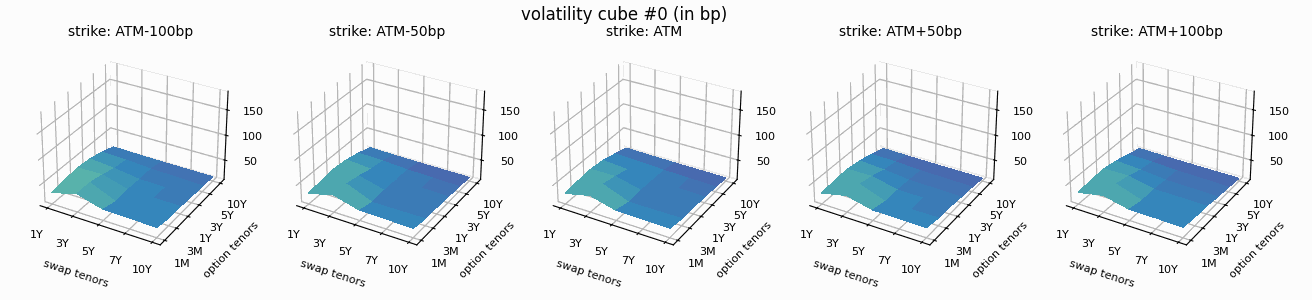

In [26]:
from src.visualization.vol.gif_vol_cube_generate_randomly import gif_vol_cube_generate_randomly

gif_vol_cube_generate_randomly(vae,
                               normalizer,
                               x_labels=swap_tenors,
                               y_labels=opt_tenors,
                               strikes=strikes,
                               delete_pngs=True,
                               z_number=20
                               )

### Robust to small changes (N=1000 takes 5 minutes)

In [26]:
import numpy as np

N = 1_000
SHIFT = 0.01
mean = np.zeros(vae.latent_space_dim)
cov = np.eye(vae.latent_space_dim)
np.random.seed(0)
z_initial_vals = np.random.multivariate_normal(mean, cov, N)

mse_worst = 0
diff_worst = None

for i in range(N):
    # Create vol cube from the random point
    gen_vol_cube_initial = normalizer.denormalize(vae.decoder.predict(np.expand_dims(z_initial_vals[i],0), verbose=0))
    # Create vol cubes moving from the random point in different directions
    for i_dir in range(vae.latent_space_dim):  
        # Plus SHIFT
        z = z_initial_vals[i].copy()
        z[i_dir] += SHIFT
        gen_vol_cube = normalizer.denormalize(vae.decoder.predict(np.expand_dims(z,0), verbose=0))
        diff = gen_vol_cube - gen_vol_cube_initial
        mse = abs(diff).max()
        if mse > mse_worst:
            mse_worst = mse
            diff_worst = diff
        # Minus SHIFT
        z = z_initial_vals[i].copy()
        z[i_dir] -= SHIFT
        gen_vol_cube = normalizer.denormalize(vae.decoder.predict(np.expand_dims(z,0), verbose=0))
        diff = gen_vol_cube - gen_vol_cube_initial
        mse = abs(diff).max()
        if mse > mse_worst:
            mse_worst = mse
            diff_worst = diff

The maximum shift in volatility cube over all data points and all test dates

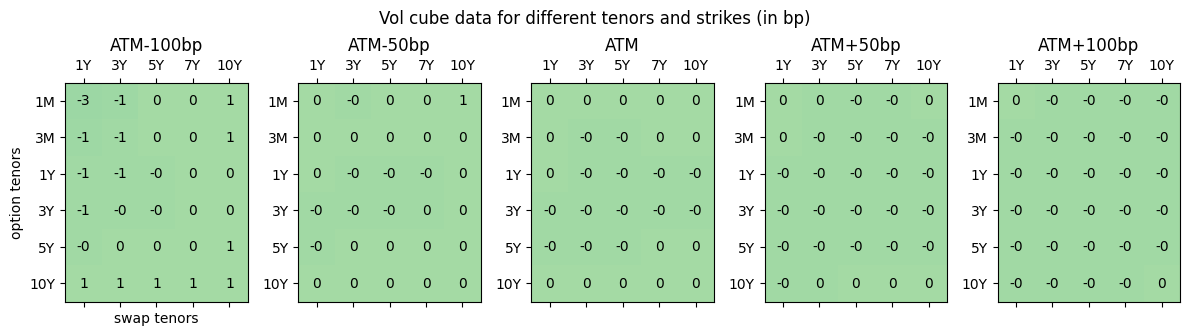

In [27]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube
grids_vol_cube(data=diff_worst[0],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)